# Application of Graph Neural Networks on Predicting Material Properties from Node Group Connectivity Matrices: Model Training and Evaluation Notebook

## 1. Initial setup
To begin model training an evaluation, first, we must import the necessary libraries, set certain control flags, intialize the parameter sweep settings, and import the main dataset.

In [2]:
# Import standard libraries
import os, json, itertools, sys
from pathlib import Path
from datetime import datetime

# Import external libraries
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch_geometric
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch import nn
from torch.nn import Linear, Dropout
from torch_geometric.data import Data, DataLoader, Batch
from torch_geometric.nn import GCNConv, global_mean_pool as gap, global_max_pool as gmp
import warnings
warnings.filterwarnings("ignore")

# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Import custom modules
root_dir = "../"
sys.path.append(root_dir + "utils")
from processing import construct_graph_data
from training import train_epoch, mse_over_loader
from evaluation import evaluate_model, regression_metrics, visualize_compliance_matrices_dual

models_dir = "../models"
sys.path.append(root_dir + "models")
from models import GCN, GAT

import warnings
warnings.filterwarnings("ignore")

In [3]:
# ---- Control flags ----
DO_PRELOAD = True        # Load saved models BEFORE training (warm start)
DO_TRAIN   = False         # Train models in this run
DO_SAVE    = False         # Save models after (optional) training
DO_EVAL    = True         # Evaluate and plot
DO_SWEEP   = False        # Run a parameter sweep as part of training (replaces default training loops)

# ---- Checkpoint paths (used for preload and save/reload) ----
save_dir = "../models/saved_models"
os.makedirs(save_dir, exist_ok=True)
attn_ckpt_path = os.path.join(save_dir, "gnn_attention_checkpoint.pth")
gcn_ckpt_path  = os.path.join(save_dir, "gnn_gcn_checkpoint.pth")

# ---- Sweep grids (edit as desired) ----
# GCN sweep grids
SWEEP_GCN_EPOCHS        = (400,)         # use smaller epochs for quick sweeps
SWEEP_GCN_LR            = (5e-4, 1e-3)
SWEEP_GCN_HIDDEN_DIM    = (128, 256)
SWEEP_GCN_NUM_CONVS     = (1, 2)
SWEEP_GCN_MLP_LAYERS    = (2,)
SWEEP_GCN_HIDDEN_NEUR   = (128, 256)
SWEEP_GCN_DROPOUT       = (0.0, 0.1)

# Attention sweep grids
SWEEP_ATTN_EPOCHS       = (400,)
SWEEP_ATTN_LR           = (5e-4, 1e-3)
SWEEP_ATTN_HIDDEN_DIM   = (64, 128)
SWEEP_ATTN_NUM_LAYERS   = (3, 4)
SWEEP_ATTN_NUM_HEADS    = (4,)
SWEEP_ATTN_MLP_LAYERS   = (2,)
SWEEP_ATTN_HIDDEN_NEUR  = (128,)
SWEEP_ATTN_DROPOUT      = (0.1,)

In [4]:
# Import data
data_dir = "../data"
data = pd.read_pickle(os.path.join(data_dir, "connectivity_compliance_matrices.pkl"))
data.rename(columns={'ρ': 'rho'}, inplace=True)

# Compute mean Young's moduli, shear moduli, and Poisson's ratios (extrapolated from compliance matrices)
data['youngs_moduli'] = data[['E1', 'E2', 'E3']].mean(axis=1)
data['shear_moduli'] = data[['G12', 'G23', 'G13']].mean(axis=1)

# Extract relevant columns
feature_cols = ['connectivity_matrix', 'rho']
target_cols = ['compliance_matrix', 'youngs_moduli', 'shear_moduli']
X = data[feature_cols + target_cols]
display(X.head())

# Extract a sample row for visualization
sample_row = X.iloc[0]

,connectivity_matrix,rho,compliance_matrix,youngs_moduli,shear_moduli
0,"[[0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0,...",0.3,"[[16.2442166588418, -4.390589663678543, -4.392...",0.061528,0.025630
1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.3,"[[22.194443522542244, -7.184492662134119, -7.1...",0.045108,0.026479
2,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.3,"[[21.44865815819801, -6.467827160497426, -6.44...",0.046636,0.024248
3,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.3,"[[15.247634909853652, -3.931170890685161, -3.9...",0.065567,0.027231
4,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.3,"[[23.16273271145176, -5.511611078765939, -5.66...",0.043226,0.019963


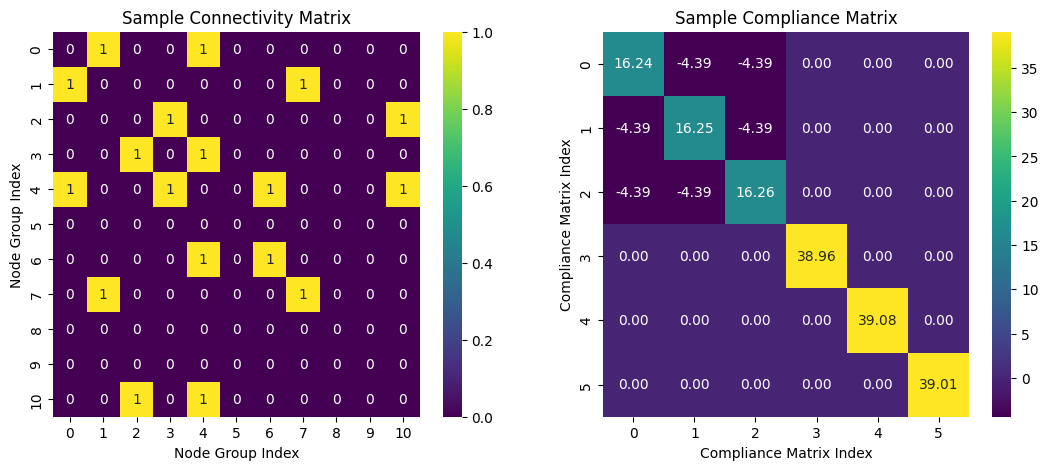

In [5]:
# Visualize sample connectivity matrix and compliance matrix
fig, ax = plt.subplots(1, 2, figsize=(13, 5))
sns.heatmap(sample_row['connectivity_matrix'], ax=ax[0], cmap='viridis', annot=True)
ax[0].set_title('Sample Connectivity Matrix')
ax[0].set_xlabel('Node Group Index')
ax[0].set_ylabel('Node Group Index')
sns.heatmap(sample_row['compliance_matrix'], ax=ax[1], cmap='viridis', annot=True, fmt=".2f")
ax[1].set_title('Sample Compliance Matrix')
ax[1].set_xlabel('Compliance Matrix Index')
ax[1].set_ylabel('Compliance Matrix Index')
plt.show()


## 2. Model Input Processing
This step consists of preparing the features and target from the main dataset to be fed into the GNN. To do so, we construct the edge index from the connectivity matrix, build the node features from the subnode information, and create edge weights from the minimum distance between each node group. This process is done across each sample of our dataset, which is then split into training and testing set and batched into PyTorch's `DataLoader`.

In [6]:
# Apply transformations to each row to prepare for GNN input
graph_data_list = X.apply(construct_graph_data, axis=1).tolist()
print(f"Constructed {len(graph_data_list)} graph data objects.")

train_data, test_data = train_test_split(graph_data_list, test_size=0.2, random_state=42)
print(f"Training set size: {len(train_data)}")
print(f"Testing set size: {len(test_data)}")
print('len(y) per graph =', len(train_data[0].y))
print(train_data[0])

num_node_features = int(train_data[0].x.shape[1])  # features per node
output_dim = int(train_data[0].y.shape[0])        # flattened compliance matrix length
num_nodes = int(np.sqrt(output_dim))
print(f"Node features per node: {num_node_features}")
print(f"Number of nodes per graph (sqrt of output dim): {num_nodes}")
print(f"Output dim (flattened compliance matrix): {output_dim}")

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_data,  batch_size=32, shuffle=False)

Constructed 2624 graph data objects.
Training set size: 2099
Testing set size: 525
len(y) per graph = 36
Data(x=[11, 11], edge_index=[2, 21], edge_attr=[21, 1], y=[36], rho=[1])
Node features per node: 11
Number of nodes per graph (sqrt of output dim): 6
Output dim (flattened compliance matrix): 36


## 3. Model Initialization and Training
Initialize the models based on default or saved parameters, based on the control flags set at the top of the notebook. A parameter sweep is performed if specified, which goes through each configuration of parameters in an attempt to find the best model based on training MSE.

In [7]:
# Build models with default params
model_attn = GAT(
    in_channels=num_node_features,
    hidden_dim=64,
    out_dim=output_dim,
    num_heads=4,
    num_layers=3,
    mlp_layers=2,
    hidden_neurons=128,
    dropout=0.1,
).to(device)

model_gcn = GCN(
    in_channels=num_node_features,
    embedding_size=128,
    out_dim=output_dim,
    dropout=0.0,
    mlp_layers=2,
    hidden_neurons=128,
    num_convs=1
).to(device)

# Set loss function and optimizers
loss_fn = torch.nn.MSELoss(reduction='mean')
optimizer_attn = torch.optim.Adam(model_attn.parameters(), lr=0.0005)
optimizer_gcn  = torch.optim.Adam(model_gcn.parameters(), lr=0.0005)

In [8]:
# Control flag activations

# ---- Optional: preload saved weights BEFORE training (warm start) ----
if DO_PRELOAD:
    if os.path.isfile(attn_ckpt_path):
        ckpt = torch.load(attn_ckpt_path, map_location=device)
        model_attn.load_state_dict(ckpt["model_state_dict"])
        print(f"Preloaded Attention weights from {attn_ckpt_path}")  # state_dict best-practice [web:257]
    else:
        print(f"Attention preload path not found: {attn_ckpt_path}")
    if os.path.isfile(gcn_ckpt_path):
        ckpt = torch.load(gcn_ckpt_path, map_location=device)
        model_gcn.load_state_dict(ckpt["model_state_dict"])
        print(f"Preloaded GCN weights from {gcn_ckpt_path}")
    else:
        print(f"GCN preload path not found: {gcn_ckpt_path}")

if DO_TRAIN and DO_SWEEP:
    # ---------- Parameter Sweep ----------
    sweep_rows = []

    # GCN sweep
    for ep, lr, hd, nconv, mlp, hn, do in itertools.product(
        SWEEP_GCN_EPOCHS, SWEEP_GCN_LR, SWEEP_GCN_HIDDEN_DIM,
        SWEEP_GCN_NUM_CONVS, SWEEP_GCN_MLP_LAYERS, SWEEP_GCN_HIDDEN_NEUR,
        SWEEP_GCN_DROPOUT
    ):
        cfg = dict(model="gcn", epochs=ep, lr=lr, hidden_dim=hd, num_convs=nconv,
                   mlp_layers=mlp, hidden_neurons=hn, dropout=do)
        # Build per-config model
        conv_channels = [int(hd)] * int(nconv)
        m = GCN(
            in_channels=num_node_features,
            embedding_size=int(hd),
            out_dim=output_dim,
            dropout=float(do),
            mlp_layers=int(mlp),
            hidden_neurons=int(hn),
            num_convs=int(nconv),
            conv_channels=conv_channels
        ).to(device)
        opt = torch.optim.Adam(m.parameters(), lr=float(lr))
        # Train
        for e in range(int(ep)):
            _ = train_epoch(m, train_loader, opt, loss_fn, device)
        # Evaluate quick MSE on test
        test_mse = mse_over_loader(m, test_loader, device)
        sweep_rows.append({**cfg, "test_mse": float(test_mse)})

    # Attention sweep
    for ep, lr, hd, nl, nh, mlp, hn, do in itertools.product(
        SWEEP_ATTN_EPOCHS, SWEEP_ATTN_LR, SWEEP_ATTN_HIDDEN_DIM,
        SWEEP_ATTN_NUM_LAYERS, SWEEP_ATTN_NUM_HEADS, SWEEP_ATTN_MLP_LAYERS,
        SWEEP_ATTN_HIDDEN_NEUR, SWEEP_ATTN_DROPOUT
    ):
        cfg = dict(model="attn", epochs=ep, lr=lr, hidden_dim=hd, num_layers=nl,
                   num_heads=nh, mlp_layers=mlp, hidden_neurons=hn, dropout=do)
        # Build per-config model
        m = GAT(
            in_channels=num_node_features,
            hidden_dim=int(hd),
            out_dim=output_dim,
            num_heads=int(nh),
            num_layers=int(nl),
            mlp_layers=int(mlp),
            hidden_neurons=int(hn),
            dropout=float(do),
        ).to(device)
        opt = torch.optim.Adam(m.parameters(), lr=float(lr))
        # Train
        for e in range(int(ep)):
            _ = train_epoch(m, train_loader, opt, loss_fn, device)
        # Evaluate quick MSE on test
        test_mse = mse_over_loader(m, test_loader, device)
        sweep_rows.append({**cfg, "test_mse": float(test_mse)})

    sweep_df = pd.DataFrame(sweep_rows).sort_values(by="test_mse", ascending=True).reset_index(drop=True)
    print("Sweep results (best first):")
    display(sweep_df.head(10))

elif DO_TRAIN and not DO_SWEEP:
    # ---------- Default training ----------
    print("Starting training (Attention)...")
    attn_losses, EPOCHS = [], 2500
    for epoch in range(EPOCHS):
        train_loss = train_epoch(model_attn, train_loader, optimizer_attn, loss_fn, device)
        attn_losses.append(train_loss)
        if epoch % 5 == 0:
            print(f"[ATTN] Epoch {epoch} | Train MSE {train_loss:.6f}")
    sns.set(style="whitegrid")
    ax = sns.lineplot(x=list(range(len(attn_losses))), y=attn_losses)
    ax.set(xlabel="Epoch", ylabel="Mean Squared Error (MSE)")
    plt.title("Attention Model Training Loss"); plt.show()

    print("Starting training (GCN)...")
    gcn_losses, EPOCHS = [], 2500
    for epoch in range(EPOCHS):
        train_loss = train_epoch(model_gcn, train_loader, optimizer_gcn, loss_fn, device)
        gcn_losses.append(train_loss)
        if epoch % 5 == 0:
            print(f"[GCN] Epoch {epoch} | Train MSE {train_loss:.6f}")
    sns.set(style="whitegrid")
    ax = sns.lineplot(x=list(range(len(gcn_losses))), y=gcn_losses)
    ax.set(xlabel="Epoch", ylabel="Mean Squared Error (MSE)")
    plt.title("GCN Model Training Loss"); plt.show()


Preloaded Attention weights from ../models/saved_models/gnn_attention_checkpoint.pth
Preloaded GCN weights from ../models/saved_models/gnn_gcn_checkpoint.pth


## 4. Model Evaluation and Metrics
The models are evaluated by first generating predictions for each split, calculating the regression metrics (MAE, MSE, RMSE, and R<sup>2</sup>), and plotting the results. Sample compliance matrices are also visualized against the predicted matrices for each model, for a more granular look into each prediction.

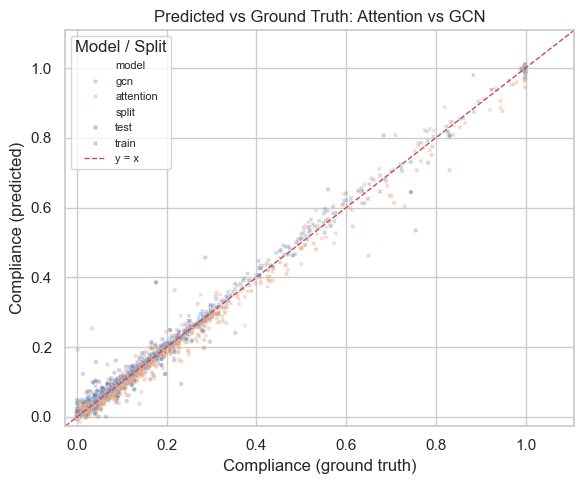

Attention metrics: {'MAE': 0.00823308527469635, 'MSE': 0.00024697312619537115, 'RMSE': 0.015715378652624668, 'R2': 0.9968576593782431}
GCN metrics: {'MAE': 0.007370175328105688, 'MSE': 0.00027414553915150464, 'RMSE': 0.016557340944472473, 'R2': 0.9965119336106657}


In [9]:
if DO_EVAL:
    loader_dict = {"train": train_loader, "test": test_loader}
    attn_df = evaluate_model(loader_dict, model_attn, device, "attention")
    gcn_df = evaluate_model(loader_dict, model_gcn,  device, "gcn")

    all_df = pd.concat([attn_df, gcn_df], ignore_index=True)
    sns.set(style="whitegrid")
    fig, ax = plt.subplots(figsize=(6, 5))
    sns.scatterplot(
        data=all_df.sample(min(len(all_df), 5000), random_state=0),
        x="y_true", y="y_pred", hue="model", style="split",
        alpha=0.3, s=10, ax=ax
    )
    xy_min = float(min(all_df["y_true"].min(), all_df["y_pred"].min()))
    xy_max = float(max(all_df["y_true"].max(), all_df["y_pred"].max()))
    ax.axline((0, 0), slope=1.0, color="r", linestyle="--", linewidth=1.0, label="y = x")
    ax.set_xlim(xy_min, xy_max); ax.set_ylim(xy_min, xy_max)
    ax.set_xlabel("Compliance (ground truth)"); ax.set_ylabel("Compliance (predicted)")
    ax.legend(title="Model / Split", fontsize=8); ax.set_title("Predicted vs Ground Truth: Attention vs GCN")
    plt.tight_layout(); plt.show()

    print("Attention metrics:", regression_metrics(attn_df["y_true"].values, attn_df["y_pred"].values))
    print("GCN metrics:", regression_metrics(gcn_df["y_true"].values,  gcn_df["y_pred"].values))


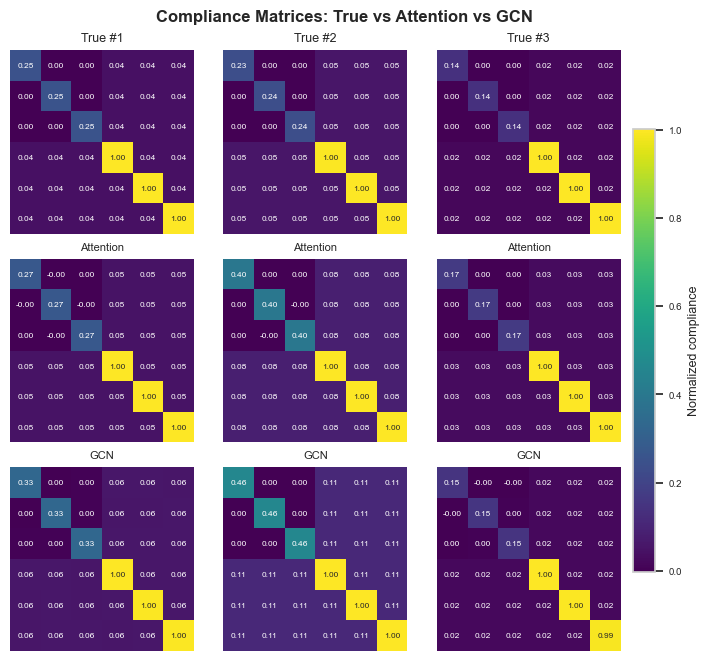

In [10]:
if DO_EVAL:
    visualize_compliance_matrices_dual(
        model_attn=model_attn,
        model_gcn=model_gcn,
        dataset=test_data,
        device=device,
        num_examples=3,
        fmt=".2f"
    )

In [11]:
# ---- Optional: save model checkpoints ----
if DO_SAVE:
    torch.save(
        {
            "model_state_dict": model_attn.state_dict(),
            "optimizer_state_dict": optimizer_attn.state_dict(),
            "num_node_features": num_node_features,
            "output_dim": output_dim,
        },
        attn_ckpt_path,
    )
    print(f"Saved attention model checkpoint to {attn_ckpt_path}")  # state_dict pattern [web:257]

    torch.save(
        {
            "model_state_dict": model_gcn.state_dict(),
            "optimizer_state_dict": optimizer_gcn.state_dict(),
            "num_node_features": num_node_features,
            "output_dim": output_dim,
        },
        gcn_ckpt_path,
    )
    print(f"Saved GCN model checkpoint to {gcn_ckpt_path}")
